In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as w 
w.filterwarnings('ignore')

In [1]:
df = pd.read_csv('../artifacts/raw.csv')

NameError: name 'pd' is not defined

In [3]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,Data Quality Analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,Data Quality Analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,Applied Scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,Applied Scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M


In [4]:
df.shape

(141566, 11)

In [5]:
df['exchange_rate']=  (df['salary']/df['salary_in_usd']).round(2)
df['experience_level'] = df['experience_level'].map({'EN':0,
                                                     'MI':1,
                                                     'SE':2,
                                                     'EX':3})
df['employment_type'] = df['employment_type'].map({'FL':0,
                                                     'PT':1,
                                                     'CT':2,
                                                     'FT':3})
df['company_size'] = df['company_size'].map({'S':0,
                                             'M':1,
                                            'L':2})
df['is_location_same']= (df['employee_residence']== df['company_location']).astype(int)
df = df.drop('salary', axis=1)

In [6]:
df['is_location_same'].value_counts()

is_location_same
1    141410
0       156
Name: count, dtype: int64

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
import lightgbm as lgb

In [8]:
train , test = train_test_split(df, random_state=42, test_size=0.3)

In [11]:
train.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'exchange_rate',
       'is_location_same'],
      dtype='object')

In [ ]:
X= train.drop(columns=['salary_in_usd'], axis=1)
y = np.log1p(train['salary_in_usd'])

X_features= test.drop(columns=['salary_in_usd'], axis=1)
y_test = test['salary_in_usd']

num= X.select_dtypes(include=['number']).columns.tolist()
cat= X.select_dtypes(include=['object']).columns.tolist()

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                     ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('scaler', OneHotEncoder(drop= 'first', handle_unknown='ignore', sparse_output=False))])

preprocessing = ColumnTransformer([('pipe1', num_pipe, num),
                                   ('pipe', cat_pipe, cat)])

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

models=[]
oof_pred = np.zeros(len(X))
test_pred = np.zeros(len(X_features))
for fold, (train_idx, val_idx) in enumerate(folds.split(X,y)):
    X_train_raw, X_val_raw = X.iloc[train_idx], X.iloc[val_idx]
    y_train , y_val = y.iloc[train_idx], y.iloc[val_idx]
    X_train = preprocessing.fit_transform(X_train_raw, X_val_raw)
    X_val = preprocessing.transform(X_val_raw)

    dtrain = lgb.Dataset(X_train, label= y_train)
    dval = lgb.Dataset(X_val, label= y_val)

    params = {
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "max_depth": 7,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 1.0,
    "lambda_l2": 1.0,
    "random_state": 42,
    "n_jobs": -1
    }
    
    model = lgb.train(params, dtrain, valid_sets=[dtrain, dval],
                      num_boost_round=150)
    y_pred = model.predict(X_val)
    y_pred = np.expm1(y_pred)
    oof_pred[val_idx]= y_pred
    X_features_transformed = preprocessing.transform(X_features)
    test_pred += model.predict(X_features_transformed)/folds.n_splits

    models.append(model)

test_pred = np.expm1(test_pred)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 79276, number of used features: 218
[LightGBM] [Info] Start training from score 11.856247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

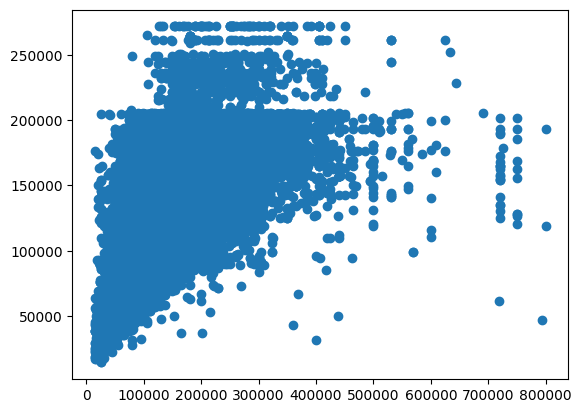

In [45]:
plt.scatter(y_test, test_pred)

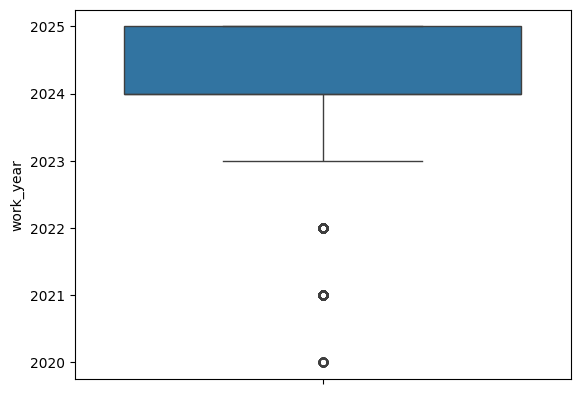

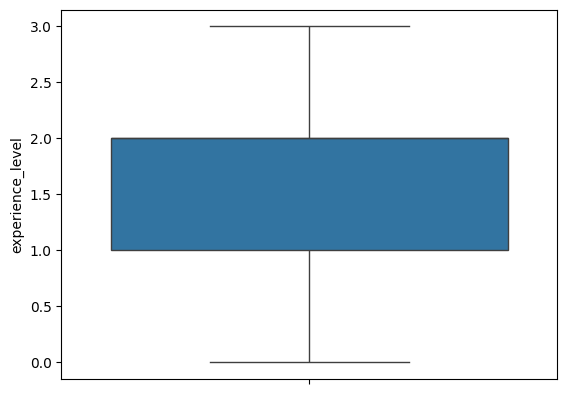

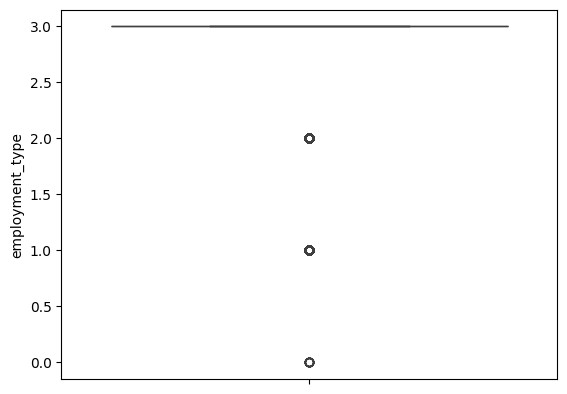

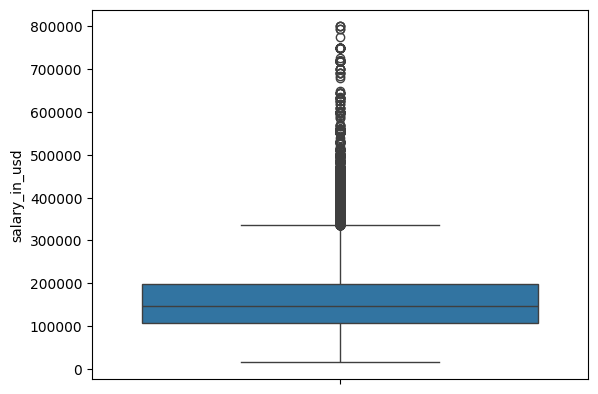

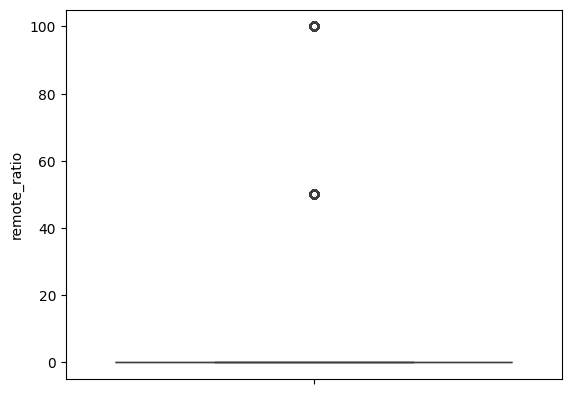

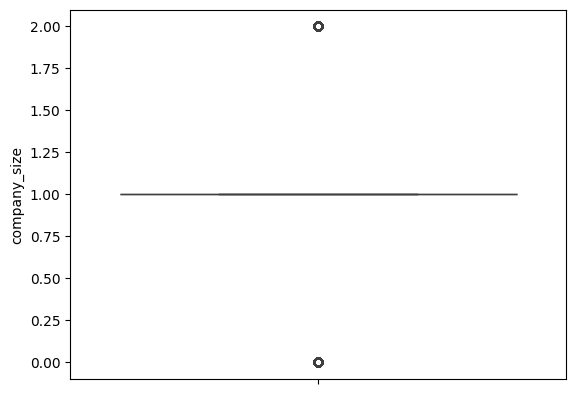

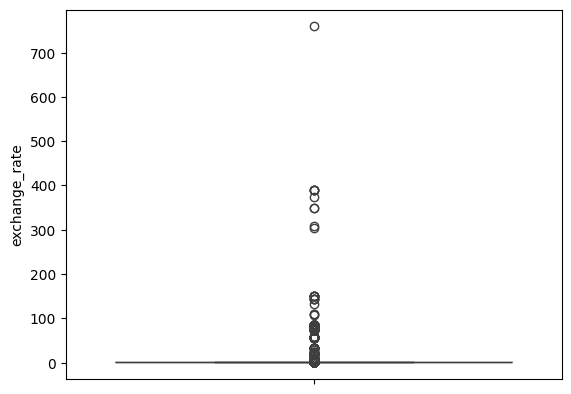

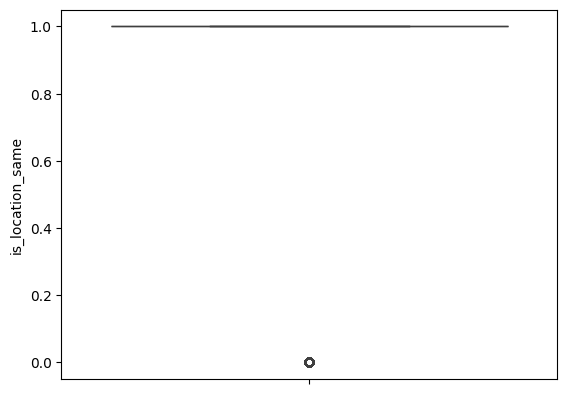

In [44]:
num= df.select_dtypes(include=['number']).columns.tolist()
for i in num:
    sns.boxplot(df[i])
    plt.show()